In [1]:
# Add higher directory to python modules path

import sys

sys.path.append("..")

In [2]:
import os
import yaml

from tqdm import tqdm

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib_venn import venn2

import bacdive

In [3]:
with open("../config.yaml", mode="r") as handle:
    config = yaml.safe_load(handle)

In [4]:
DATA_DIR = "../data/"

## 1. Taxon to media sources

### KOMODO

* **komodo_taxa.txt**: downloaded from [KOMODO](https://komodo.modelseed.org/servlet/KomodoTomcatServerSideUtilitiesModelSeed?OrganismMedia)

* **komodo_media.txt**: downloaded from [KOMODO](https://komodo.modelseed.org/servlet/KomodoTomcatServerSideUtilitiesModelSeed?MediaList)

In [5]:
komodo_taxa = pd.read_table(
    os.path.join(
        DATA_DIR,
        "komodo",
        "komodo_taxa.txt"
    )
)

komodo_taxa["taxon_id"] = komodo_taxa["taxon_id"]\
    .astype(str)\
    .replace(r".0$", "", regex=True)

komodo_taxa

,dsmz_id,taxon_id,organism_name,media_name
0,6268,nan,NaN,Substrate for DSM 6268
1,9849,46125,Abiotrophia defectiva,PYG-MEDIUM (modified)
2,14247,291968,Acaricomes phytoseiuli,TRYPTICASE SOY Yeast extract medium
3,23669,nan,Acetatifactor muris,For DSM 23669
4,5522,2382,Acetitomaculum ruminis,ACETITOMACULUM medium | METHANOBACTERIUM medium
...,...,...,...,...
8623,473,120045,Zymomonas mobilis subsp. mobilis,ZYMOMONAS medium
8624,22645,120044,Zymomonas mobilis subsp. pomaceae,ZYMOMONAS medium
8625,7201,86958,Zymophilus paucivorans,MEDIUM 58 MODIFIED FOR DSM 7201
8626,20765,86959,Zymophilus raffinosivorans,MEDIUM 58 MODIFIED FOR DSM 20765


In [6]:
komodo_media = pd.read_table(
    os.path.join(
        DATA_DIR,
        "komodo",
        "komodo_media.txt"
    )
)
komodo_media

,media_id,media_name,ph,complex,aerobic,submedium,instructions
0,1,NUTRIENT AGAR,7.0,True,False,False,http://www.dsmz.de/microorganisms/medium/pdf/D...
1,10,ZYMOMONAS medium,NaN,True,False,False,http://www.dsmz.de/microorganisms/medium/pdf/D...
2,1000,MJANHOX-NO3 MEDIUM WITH SUPPLEMENT,7.5 - 8.0,False,True,False,http://www.dsmz.de/microorganisms/medium/pdf/D...
3,1001,BASAL MEDIUM,6.8 - 7,False,True,False,http://www.dsmz.de/microorganisms/medium/pdf/D...
4,1002,ECTOTHIORHODOSYNUS medium,9 - 9.5,True,False,False,http://www.dsmz.de/microorganisms/medium/pdf/D...
...,...,...,...,...,...,...,...
3632,9_53191,MEDIUM 9 MODIFIED FOR DSM 53191,NaN,True,False,False,http://www.dsmz.de/microorganisms/medium/pdf/D...
3633,9_53271,MEDIUM 9 MODIFIED FOR DSM 53271,NaN,True,False,False,http://www.dsmz.de/microorganisms/medium/pdf/D...
3634,9_53343,MEDIUM 9 MODIFIED FOR DSM 53343,NaN,True,False,False,http://www.dsmz.de/microorganisms/medium/pdf/D...
3635,9_53796,MEDIUM 9 MODIFIED FOR DSM 53796,NaN,True,False,False,http://www.dsmz.de/microorganisms/medium/pdf/D...


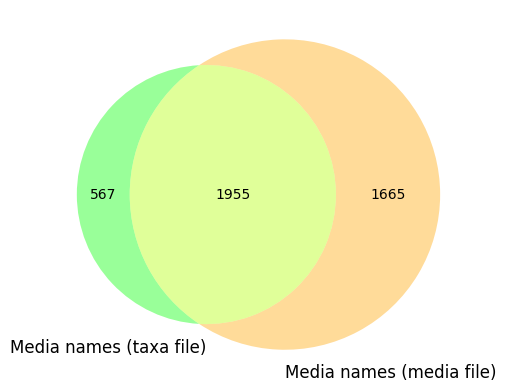

In [7]:
venn2(
    subsets=[
        set(komodo_taxa["media_name"]),
        set(komodo_media["media_name"])
    ],
    set_labels=[
        "Media names (taxa file)",
        "Media names (media file)"
    ],
    set_colors=[
        "lime",
        "orange"
    ]
)

In [8]:
komodo_df = pd.merge(
    left=komodo_taxa,
    right=komodo_media,
    on="media_name",
    how="outer",
    indicator=True
)

# Add extra column indicating the source of the data
komodo_df = komodo_df.rename(columns={"_merge": "source"})
komodo_df["source"] = komodo_df["source"]\
    .cat.rename_categories({
        "right_only": "komodo_taxa.txt",
        "left_only": "komodo_media.txt"
    })

# Format missing values
komodo_df = komodo_df.replace("nan", np.nan)

komodo_df.to_csv(
    os.path.join(
        DATA_DIR,
        "processed",
        "komodo.csv"
    ),
    sep=";",
    index=False
)

komodo_df

,dsmz_id,taxon_id,organism_name,media_name,media_id,ph,complex,aerobic,submedium,instructions,source
0,NaN,NaN,NaN,1/10 NUTRIENT AGAR NO.2,952,7.0 - 7.2,True,False,False,http://www.dsmz.de/microorganisms/medium/pdf/D...,komodo_taxa.txt
1,21034,NaN,Rhizomicrobium electricum,1/10 PYGV medium modified,1398,7.0,True,True,False,http://www.dsmz.de/microorganisms/medium/pdf/D...,both
2,NaN,NaN,NaN,1/100 NUTRIENT AGAR NO.2,953,7.0 - 7.2,True,False,False,http://www.dsmz.de/microorganisms/medium/pdf/D...,komodo_taxa.txt
3,12412,44255,Agromonas oligotrophica,1/100 NUTRIENT AGAR NO.2 | 1/10 NUTRIENT AGAR ...,NaN,NaN,NaN,NaN,NaN,NaN,komodo_media.txt
4,22777,NaN,Sphaerochaeta globosa,1/2 TRYPTIC SOY BROTH (ANAEROBE),1205,"7.2, HCl",True,False,False,http://www.dsmz.de/microorganisms/medium/pdf/D...,both
...,...,...,...,...,...,...,...,...,...,...,...
10317,18958,56450,Xanthomonas cassavae,NaN,NaN,NaN,NaN,NaN,NaN,NaN,komodo_media.txt
10318,18797,56464,Xanthomonas theicola,NaN,NaN,NaN,NaN,NaN,NaN,NaN,komodo_media.txt
10319,14987,263819,Yersinia aleksiciae,NaN,NaN,NaN,NaN,NaN,NaN,NaN,komodo_media.txt
10320,25701,NaN,Zhongshania antarctica,NaN,NaN,NaN,NaN,NaN,NaN,NaN,komodo_media.txt


### MediaDive

In [9]:
import modules.mediadive as md

In [27]:
md_media_df = md.get_media()

md_media_df = md_media_df.rename(columns={"id": "media_id"})

md_media_df.to_csv(
    os.path.join(
        DATA_DIR,
        "mediadive",
        "mediadive-media.csv"
    ),
    index=False
)

md_media_df

,media_id,name,complex_medium,source,link,min_pH,max_pH,reference,description
0,1,NUTRIENT AGAR,1,DSMZ,https://www.dsmz.de/microorganisms/medium/pdf/...,7.0,7.0,None,None
1,1a,REACTIVATION WITH LIQUID MEDIUM 1,1,DSMZ,https://www.dsmz.de/microorganisms/medium/pdf/...,7.0,7.0,None,None
2,2,BACILLUS PASTEURII MEDIUM,1,DSMZ,https://www.dsmz.de/microorganisms/medium/pdf/...,NaN,NaN,None,None
3,3,AZOTOBACTER MEDIUM,0,DSMZ,https://www.dsmz.de/microorganisms/medium/pdf/...,7.3,7.3,None,None
4,6,ALLANTOIN MINERAL MEDIUM,1,DSMZ,https://www.dsmz.de/microorganisms/medium/pdf/...,NaN,NaN,None,None
...,...,...,...,...,...,...,...,...,...
3307,P5,RS Medium - Nutrient Medium (NM) Component,1,public,None,7.0,7.0,None,The RS medium is a fully defined medium design...
3308,P6,mTA10,1,public,None,7.2,7.2,10.1016/j.foodcont.2012.06.029,None
3309,P7,N27 RHODOSPIRILLACEAE MEDIUM (modified),1,public,None,6.8,6.8,None,None
3310,P8,M9-SNG medium,1,public,None,7.2,7.2,10.1007/s11104-022-05822-6,Myrosinase producing bacteria and fungi enric...


In [11]:
media_id_list = md_media_df["id"].astype(str).unique()

In [15]:
md_comp_df = md.get_composition(media_id_list)

md_comp_df.to_csv(
    os.path.join(
        DATA_DIR,
        "mediadive",
        "mediadive-media-comp.csv"
    ),
    sep=";",
    index=False
)

md_comp_df

100%|██████████| 3312/3312 [11:15<00:00,  4.91it/s]


,media_id,components,component_ids
0,1,"[Peptone, Meat extract, Agar, Distilled water]","[1, 2, 3, 4]"
1,1a,"[Peptone, Meat extract, Agar, Distilled water]","[1, 2, 3, 4]"
2,2,"[Main sol. 1, Urea, Peptone, Meat extract, Aga...","[1, 339, 1, 2, 3, 4]"
3,3,"[Glucose, Mannitol, CaCl2 x 2 H2O, MgSO4 x 7 H...","[5, 6, 7, 8, 9, 10, 11, 12, 13, 3, 4]"
4,6,"[K2HPO4, KH2PO4, MgSO4 x 7 H2O, CaCl2 x 2 H2O,...","[10, 11, 8, 7, 12, 14, 15, 3, 4]"
...,...,...,...
3307,P5,[],[]
3308,P6,[],[]
3309,P7,[],[]
3310,P8,[],[]


In [17]:
md_strains_df = md.get_strains(media_id_list)

md_strains_df.to_csv(
    os.path.join(
        DATA_DIR,
        "mediadive",
        "mediadive-media-strains.csv"
    ),
    sep=";",
    index=False
)

md_strains_df

100%|██████████| 3312/3312 [10:51<00:00,  5.09it/s]


,media_id,strain_id,species,ccno,bacdive_id
0,1,1,Heyndrickxia coagulans,DSM 1,654.0
1,1,2,Paenibacillus macquariensis subsp. macquariensis,DSM 2,11477.0
2,1,3,Sporosarcina psychrophila,DSM 3,11984.0
3,1,6,Peribacillus psychrosaccharolyticus,DSM 6,748.0
4,1,7,Bacillus amyloliquefaciens,DSM 7,598.0
...,...,...,...,...,...
68529,C109,61705,Rosculus vulgaris,CCAP1571/7,NaN
68530,C109,61863,Guttulinopsis erdosi,CCAP1926/1,NaN
68531,C109,61864,Guttulinopsis rogosis,CCAP1926/2,NaN
68532,C109,61865,Olivorum cimiterus,CCAP1942/1,NaN


In [26]:
# Merge media composition and strains info
md_df = pd.merge(
    left=md_comp_df,
    right=md_strains_df,
    on="media_id",
    how="outer",
    indicator=True
)

# Merge media information with previous data
md_df = pd.merge(
    left=md_media_df,
    right=md_df,
    on="media_id",
    how="left",
    indicator=False
)

# Add extra column indicating the source of the data
md_df = md_df.rename(columns={"_merge": "merge_source"})
md_df["merge_source"] = md_df["merge_source"]\
    .cat.rename_categories({
        "right_only": "composition_only",
        "left_only": "strains_only"
    })

md_df.to_csv(
    os.path.join(
        DATA_DIR,
        "mediadive",
        "mediadive-all.csv"
    ),
    sep=";",
    index=False
)

md_df

,media_id,name,complex_medium,source,link,min_pH,max_pH,reference,description,components,component_ids,strain_id,species,ccno,bacdive_id,merge_source
0,1,NUTRIENT AGAR,1,DSMZ,https://www.dsmz.de/microorganisms/medium/pdf/...,7.0,7.0,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1a,REACTIVATION WITH LIQUID MEDIUM 1,1,DSMZ,https://www.dsmz.de/microorganisms/medium/pdf/...,7.0,7.0,None,None,"[Peptone, Meat extract, Agar, Distilled water]","[1, 2, 3, 4]",29.0,Comamonas testosteroni,DSM 38,2912.0,both
2,1a,REACTIVATION WITH LIQUID MEDIUM 1,1,DSMZ,https://www.dsmz.de/microorganisms/medium/pdf/...,7.0,7.0,None,None,"[Peptone, Meat extract, Agar, Distilled water]","[1, 2, 3, 4]",30.0,Delftia acidovorans,DSM 39,2941.0,both
3,1a,REACTIVATION WITH LIQUID MEDIUM 1,1,DSMZ,https://www.dsmz.de/microorganisms/medium/pdf/...,7.0,7.0,None,None,"[Peptone, Meat extract, Agar, Distilled water]","[1, 2, 3, 4]",39.0,Acidovorax delafieldii,DSM 64,2885.0,both
4,1a,REACTIVATION WITH LIQUID MEDIUM 1,1,DSMZ,https://www.dsmz.de/microorganisms/medium/pdf/...,7.0,7.0,None,None,"[Peptone, Meat extract, Agar, Distilled water]","[1, 2, 3, 4]",52.0,Pseudomonas putida,DSM 84,12895.0,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31893,P5,RS Medium - Nutrient Medium (NM) Component,1,public,None,7.0,7.0,None,The RS medium is a fully defined medium design...,[],[],NaN,NaN,NaN,NaN,strains_only
31894,P6,mTA10,1,public,None,7.2,7.2,10.1016/j.foodcont.2012.06.029,None,[],[],NaN,NaN,NaN,NaN,strains_only
31895,P7,N27 RHODOSPIRILLACEAE MEDIUM (modified),1,public,None,6.8,6.8,None,None,[],[],NaN,NaN,NaN,NaN,strains_only
31896,P8,M9-SNG medium,1,public,None,7.2,7.2,10.1007/s11104-022-05822-6,Myrosinase producing bacteria and fungi enric...,[],[],NaN,NaN,NaN,NaN,strains_only


### Final table: taxon to media

## 2. EC number sources

### UniProt

In [57]:
import modules.uniprot as uni

taxon_id_list = komodo_df["taxon_id"].dropna().unique()

taxon2ec_uniprot = uni.taxon2ec(taxon_id_list)
taxon2ec_uniprot

100%|██████████| 100/100 [00:09<00:00, 10.51it/s]


,entryType,primaryAccession,uniProtkbId,taxonId,fullName,ecNumbers
0,UniProtKB unreviewed (TrEMBL),I2B2R8,I2B2R8_9BRAD,44255,Protein RecA,
1,UniProtKB unreviewed (TrEMBL),I2B2S0,I2B2S0_9BRAD,44255,glutamine synthetase,6.3.1.2
2,UniProtKB unreviewed (TrEMBL),E5LP64,E5LP64_9BRAD,44255,None,
3,UniProtKB unreviewed (TrEMBL),A0A348W6X3,A0A348W6X3_9RHOB,314263,Coenzyme A biosynthesis bifunctional protein C...,
4,UniProtKB unreviewed (TrEMBL),A0A348W724,A0A348W724_9RHOB,314263,Bifunctional enzyme IspD/IspF,
...,...,...,...,...,...,...
454,UniProtKB unreviewed (TrEMBL),A0A7C1FE83,A0A7C1FE83_9THEO,42838,Phenylalanine--tRNA ligase alpha subunit,6.1.1.20
455,UniProtKB unreviewed (TrEMBL),A0A7C1FEE0,A0A7C1FEE0_9THEO,42838,S-adenosylmethionine decarboxylase proenzyme,4.1.1.50
456,UniProtKB unreviewed (TrEMBL),A0A7C1IX96,A0A7C1IX96_9THEO,42838,Serine hydroxymethyltransferase,2.1.2.1
457,UniProtKB unreviewed (TrEMBL),A0A7C1IXL1,A0A7C1IXL1_9THEO,42838,UDP-N-acetylglucosamine--N-acetylmuramyl-(pent...,2.4.1.227


In [58]:
taxon2ec_uniprot.to_csv(
    os.path.join(
        DATA_DIR,
        "processed",
        "uniprot_taxon2ec.csv"
    ),
    sep=";",
    index=False
)

### KEGG

In [ ]:
import modules.kegg as kegg

#### Map organism name to KEGG ID (3 letter code)

The kegg-organisms.txt was obtained by downloading the data in https://rest.kegg.jp/list/genome

In [ ]:
kegg_org = pd.read_table(
    os.path.join(
        DATA_DIR,
        "kegg",
        "kegg-organisms.txt"
    ),
    names=["KEGG Taxonomy", "KEGG ID", "Organism Name", "Classification"]
)

# kegg_org[["Domain", "Kingdom", "Phylum", "Class"]] = \
#     kegg_org["Classification"].str.split(";", expand=True)

kegg_org

,KEGG Taxonomy,KEGG ID,Organism Name,Classification
0,T01001,hsa,Homo sapiens (human),Eukaryotes;Animals;Vertebrates;Mammals
1,T01005,ptr,Pan troglodytes (chimpanzee),Eukaryotes;Animals;Vertebrates;Mammals
2,T02283,pps,Pan paniscus (bonobo),Eukaryotes;Animals;Vertebrates;Mammals
3,T02442,ggo,Gorilla gorilla gorilla (western lowland gorilla),Eukaryotes;Animals;Vertebrates;Mammals
4,T01416,pon,Pongo abelii (Sumatran orangutan),Eukaryotes;Animals;Vertebrates;Mammals
...,...,...,...,...
9932,T09593,lob,Candidatus Lokiarchaeum ossiferum,Prokaryotes;Archaea;Lokiarchaeota;Lokiarchaeum
9933,T06555,psyt,Candidatus Prometheoarchaeum syntrophicum,Prokaryotes;Archaea;Lokiarchaeota;Prometheoarc...
9934,T09928,oyw,Candidatus Odinarchaeum yellowstonii,Prokaryotes;Archaea;Odinarchaeota;Odinarchaeum
9935,T03835,agw,Archaeon GW2011_AR10,Prokaryotes;Archaea;unclassified Archaea


In [ ]:
kegg_org_match = pd.merge(
    left=kegg_org,
    right=komodo_df,
    on="Organism Name",
    how="inner"
)

kegg_org_match

,KEGG Taxonomy,KEGG ID,Organism Name,Classification,Organism DSMZ ID,Taxon ID,Media,Genus
0,T00811,efe,Escherichia fergusonii,Prokaryotes;Bacteria;Enterobacterales;Escherichia,13698,564,NUTRIENT AGAR,Escherichia
1,T03986,eal,Escherichia albertii,Prokaryotes;Bacteria;Enterobacterales;Escherichia,17582,208962,TRYPTICASE SOY BROTH AGAR,Escherichia
2,T00627,ses,Salmonella enterica subsp. arizonae,Prokaryotes;Bacteria;Enterobacterales;Salmonella,9386,59203,NUTRIENT AGAR,Salmonella
3,T03709,eclz,Enterobacter hormaechei subsp. hormaechei,Prokaryotes;Bacteria;Enterobacterales;Enteroba...,12409,301105,CASO AGAR (Merck 105458),Enterobacter
4,T05545,ecan,Enterobacter cancerogenus,Prokaryotes;Bacteria;Enterobacterales;Enteroba...,17580,69218,TRYPTICASE SOY BROTH AGAR,Enterobacter
...,...,...,...,...,...,...,...,...
1737,T08588,vso,Vulcanisaeta souniana,Prokaryotes;Archaea;Thermoproteota;Vulcanisaeta,14430,164452,For DSM 14429 and DSM 14430,Vulcanisaeta
1738,T00446,tpe,Thermofilum pendens,Prokaryotes;Archaea;Thermoproteota;Thermofilum,2475,2269,THERMOFILUM PENDENS medium,Thermofilum
1739,T01283,asc,Acidilobus saccharovorans,Prokaryotes;Archaea;Thermoproteota;Acidilobus,16705,242703,For DSM 16705,Acidilobus
1740,T02380,clg,Caldisphaera lagunensis,Prokaryotes;Archaea;Thermoproteota;Caldisphaera,15908,200415,CALDISPHAERA medium,Caldisphaera


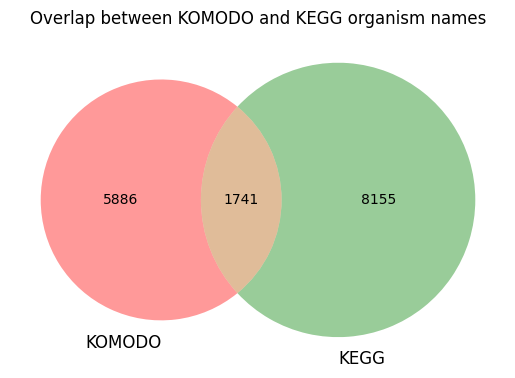

In [ ]:
from matplotlib import pyplot as plt
from matplotlib_venn import venn2

venn2(
    subsets=[
        set(komodo_df["Organism Name"]),
        set(kegg_org["Organism Name"])
    ],
    set_labels=(
        "KOMODO",
        "KEGG"
    ),
    set_colors=[
        "lime",
        "orange"
    ]
)
plt.title("Overlap between KOMODO and KEGG organism names")
plt.show()

In [ ]:
kegg.get_taxon2ec(id_list=kegg_org_match["KEGG ID"].unique())

### BacDive

In [5]:
import modules.bacdive as bd

In [6]:
md_df = pd.read_csv(
    os.path.join(
        DATA_DIR,
        "mediadive",
        "mediadive-all.csv"
    ),
    sep=";"
)

bd_id_list = md_df["bacdive_id"].dropna().astype(int).astype(str).unique()
bd_id_list

array(['2912', '2941', '2885', ..., '159029', '158241', '131423'],
      dtype=object)

In [7]:
# Initialize client
client = bacdive.BacdiveClient(config["email"], config["password"])

step = 100
results_df = []

for idx_start in tqdm(range(0, len(bd_id_list), step)):
    id_list = ";".join(bd_id_list[idx_start:idx_start+step])

    results_df.append(bd.taxon2ec(id_list=id_list, client=client))

results_df = pd.concat(
    results_df,
    axis=0,
    ignore_index=True
)

results_df = results_df.drop("reference", axis=1)

results_df.to_csv(
    os.path.join(
        DATA_DIR,
        "bacdive",
        "bacdive-all.csv"
    ),
    index=False
)

results_df.head()

-- Authentication successful --


100%|██████████| 138/138 [01:42<00:00,  1.35it/s]


,general_@ref,bacdive_id,dsmz_id,general_keywords,general_description,taxon_id,ncbi_tax_id_matching_level,strain_history_@ref,strain_history_history,general_doi,...,api_id32sta_beta_gur,physiology_and_metabolism_murein,physiology_and_metabolism_api_list,isolation_enrichment_culture,isolation_enrichment_culture_temperature,multicellular_morphology_complex_color,api_list_beta_hem,metabolite_tests_citrate_test,compound_production_excreted,isolation_enrichment_culture_duration
0,21113,24370,11532.0,"[Bacteria, human pathogen]",Pseudomonas fluorescens PWD34 is a human patho...,294,species,21113.0,"<- W. Duetz, RIVM, Bilthoven; PWD34",10.13145/bacdive24370.20240510.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,21111,24368,304.0,Bacteria,Pseudomonas sp. DSM 304 is a bacterium of the ...,306,species,21111.0,"<- IMG, 1591 (<i>P. fluorescens</i>) <- H. Stolp",10.13145/bacdive24368.20240510.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,20542,23995,30059.0,Bacteria,Lelliottia amnigena 21824 is a bacterium that ...,61646,species,20542.0,<- Bakteriologisches Institut der Sueddeutsche...,10.13145/bacdive23995.20240510.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1479,17621,3849.0,"[16S sequence, Bacteria, plant pathogen]",Xanthomonas citri subsp. malvacearum XM13 is a...,346,species,NaN,NaN,10.13145/bacdive17621.20240510.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1480,17596,3850.0,"[genome sequence, Bacteria, obligate aerobe, G...",Xanthomonas campestris DSM 3850 is an obligate...,339,species,NaN,NaN,10.13145/bacdive17596.20240510.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### NCBI

In [ ]:
# ncbi_taxon_id = bacdive.get_ncbi_id(md_df["bacdive_id"].unique())

### Final table: taxon to EC

### Final table: media to EC